## Fraud Detection Model

1. Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

2. Reading the dataset

In [2]:
df = pd.read_csv('Fraud.csv')
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


 Data Dictionary:

step - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

type - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

amount - amount of the transaction in local currency.

nameOrig - customer who started the transaction

oldbalanceOrg - initial balance before the transaction

newbalanceOrig - new balance after the transaction

nameDest - customer who is the recipient of the transaction

oldbalanceDest - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

newbalanceDest - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

isFraud - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

isFlaggedFraud - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

3. Exploring the dataset:

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [5]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [7]:
# Check rows where nameDest starts with 'M'
merchant_rows = df[df['nameDest'].str.startswith('M')]

# Check how many have oldbalanceDest = 0 and newbalanceDest = 0
zero_balances = merchant_rows[
    (merchant_rows['oldbalanceDest'] == 0) & (merchant_rows['newbalanceDest'] == 0)
]

print(f"Total merchant rows: {len(merchant_rows)}")
print(f"Merchant rows with both balances zero: {len(zero_balances)}")

Total merchant rows: 2151495
Merchant rows with both balances zero: 2151495


- All merchant rows (100%) have oldbalanceDest = 0 and newbalanceDest = 0.
- This will be an important feature for training our fraud detection model.

In [8]:
# Creating a separate flag column
df['isMerchant'] = df['nameDest'].str.startswith('M').astype(int)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0,1
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0,1
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0,1


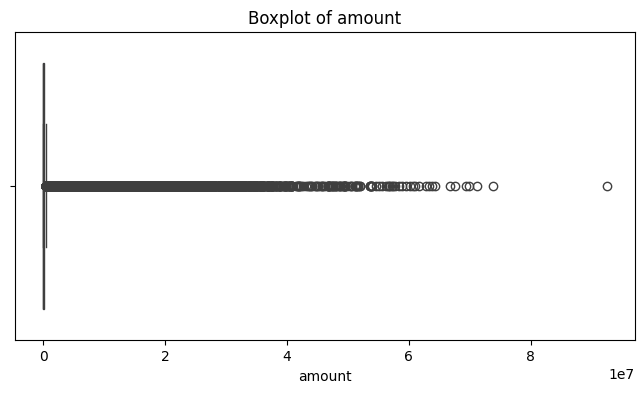

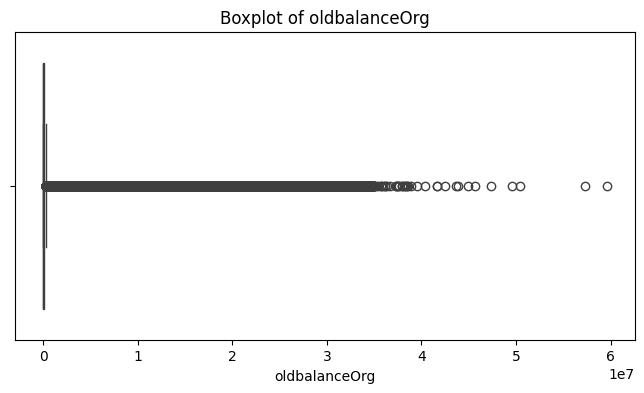

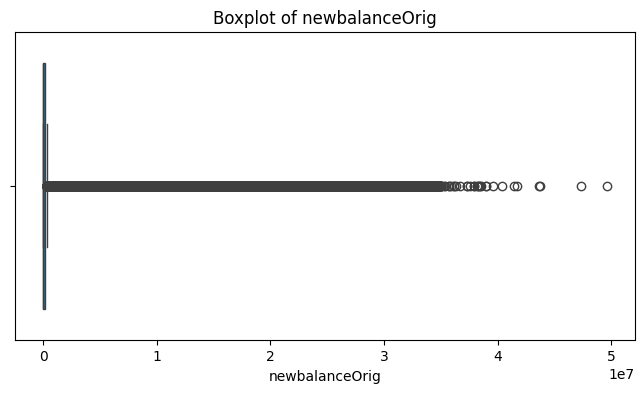

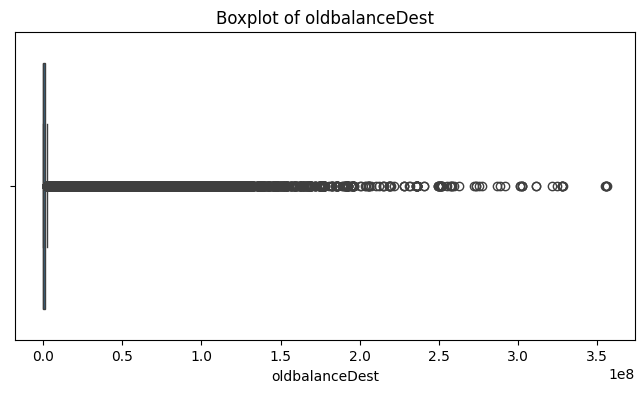

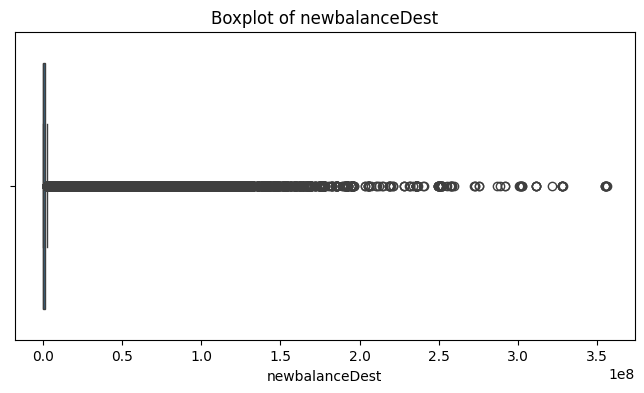

In [9]:
# List of numeric columns to check
numeric_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']

# Plot boxplots
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=df[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

- Large amounts are expected in fraud cases — removing them may kill key signals!
- We will keep these outliers as it is.

4. Data Preprocessing

In [10]:
# Drop ID columns
df = df.drop(['nameOrig', 'nameDest'], axis=1)

In [11]:
# One-hot encode 'type'
df = pd.get_dummies(df, columns=['type'], drop_first=True)

In [12]:
# Create balance difference features
df['balanceDiffOrig'] = df['oldbalanceOrg'] - df['newbalanceOrig'] - df['amount']
df['balanceDiffDest'] = df['newbalanceDest'] - df['oldbalanceDest'] - df['amount']

In [13]:
df.head()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,balanceDiffOrig,balanceDiffDest
0,1,9839.64,170136.0,160296.36,0.0,0.0,0,0,1,False,False,True,False,1.455192e-11,-9839.64
1,1,1864.28,21249.0,19384.72,0.0,0.0,0,0,1,False,False,True,False,-1.136868e-12,-1864.28
2,1,181.00,181.0,0.00,0.0,0.0,1,0,0,False,False,False,True,0.000000e+00,-181.00
3,1,181.00,181.0,0.00,21182.0,0.0,1,0,0,True,False,False,False,0.000000e+00,-21363.00
4,1,11668.14,41554.0,29885.86,0.0,0.0,0,0,1,False,False,True,False,0.000000e+00,-11668.14


<Axes: >

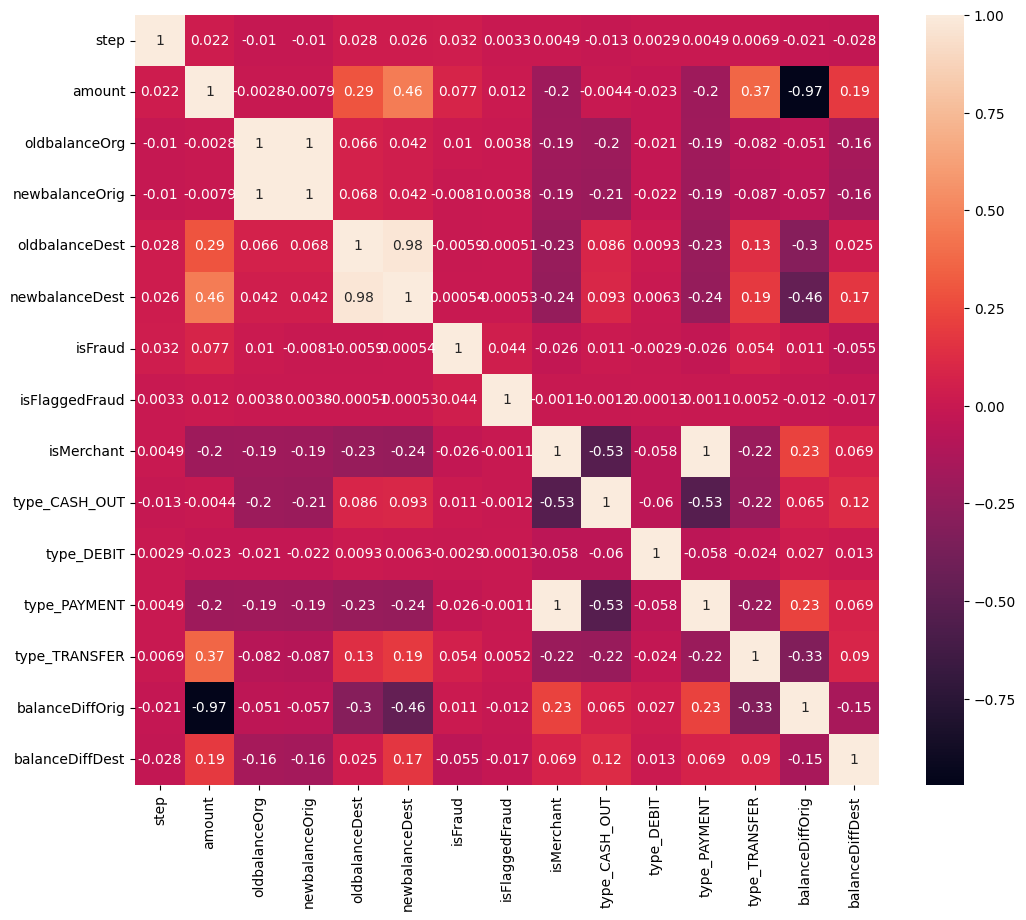

In [16]:
# Checking correlation between all the features
figure = plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True)

In [17]:
df.corr()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud,isMerchant,type_CASH_OUT,type_DEBIT,type_PAYMENT,type_TRANSFER,balanceDiffOrig,balanceDiffDest
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277,0.004926,-0.012918,0.002869,0.004926,0.006925,-0.020516,-0.028159
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295,-0.197444,-0.004376,-0.023379,-0.197444,0.365896,-0.970660,0.189928
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835,-0.189486,-0.200899,-0.021450,-0.189486,-0.081593,-0.050502,-0.156464
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776,-0.193915,-0.210977,-0.021872,-0.193915,-0.087355,-0.056897,-0.163161
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513,-0.231455,0.086028,0.009347,-0.231455,0.130476,-0.304256,0.025460
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529,-0.238315,0.093476,0.006346,-0.238315,0.191701,-0.458750,0.174942
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109,-0.025697,0.011256,-0.002911,-0.025697,0.053869,0.011283,-0.055120
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000,-0.001133,-0.001168,-0.000128,-0.001133,0.005245,-0.012183,-0.017261
isMerchant,0.004926,-0.197444,-0.189486,-0.193915,-0.231455,-0.238315,-0.025697,-0.001133,1.000000,-0.526422,-0.057868,1.000000,-0.216110,0.229066,0.068817
type_CASH_OUT,-0.012918,-0.004376,-0.200899,-0.210977,0.086028,0.093476,0.011256,-0.001168,-0.526422,1.000000,-0.059625,-0.526422,-0.222672,0.064790,0.121535


- No single feature has a strong linear correlation with isFraud.
- This is common in fraud detection — fraud patterns are often: Non-linear and Hidden in feature interactions (like amount + type together).
- To handle such non-linear patterns in the data, we will use XGBoost to handle large dataset, non-linear interaction, class imbalance, and deliver top results on tabular data.

5. Model Training

In [18]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score

In [19]:
X = df.drop(['isFraud'], axis=1)
y = df['isFraud']

In [20]:
# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [22]:
# Training XGBoost Classifier
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    scale_pos_weight=(y_train == 0).sum() / (y_train == 1).sum(),  # handle class imbalance
    use_label_encoder=False,
    eval_metric='logloss'
)
model.fit(X_train, y_train)

c:\Users\Soham\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:01:50] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [23]:
# Evaluating the model performance
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.79      1.00      0.88      1643

    accuracy                           1.00   1272524
   macro avg       0.90      1.00      0.94   1272524
weighted avg       1.00      1.00      1.00   1272524

ROC AUC: 0.999785494890037


- High recall on fraud (1.00) : model is catching all fraud cases, no misses.
- Precision on fraud (0.79) : ~21% of flagged frauds are false positives → acceptable in fraud, where catching all is priority.
- Overall accuracy (1.00) → very high, Majority class (non-fraud) dominates but accuracy can be misleading.
- But here, recall and AUC confirm real performance: ROC AUC ~1 : the model separates fraud vs. non-fraud almost perfectly.
- We will apply hyper parameter tuning on our model to tune precision for reducing false positives.

6. Hyperparameter Tuning

In [24]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import make_scorer, precision_score

In [25]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'scale_pos_weight': [(y_train == 0).sum() / (y_train == 1).sum()],
}

In [26]:
# Precision scorer for positive class (fraud = 1)
precision_scorer = make_scorer(precision_score, pos_label=1)

In [27]:
# Setup RandomizedSearch
xgb_clf = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
random_search = RandomizedSearchCV(
    estimator=xgb_clf,
    param_distributions=param_grid,
    n_iter=30,  # number of random combos
    scoring=precision_scorer,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)
random_search.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


c:\Users\Soham\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [20:35:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


RandomizedSearchCV(cv=3,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_cons...
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.7, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'max_depth': [4, 6, 8],
                                        'n_estimators': [100, 200, 300],
                                        'scale_pos_weight': [773.7482496194825],
                                        'subsample': [0.7, 0.8, 1.0]},
                   random_state=42,
                   scoring=make_scorer(precision_score, pos_label=1),
                   verbose=2)

In [28]:
# Best model
best_model = random_search.best_estimator_
print("Best parameters:", random_search.best_params_)

# Evaluate on test set
from sklearn.metrics import classification_report

y_pred = best_model.predict(X_test)
print(classification_report(y_test, y_pred))

Best parameters: {'subsample': 1.0, 'scale_pos_weight': 773.7482496194825, 'n_estimators': 300, 'max_depth': 8, 'learning_rate': 0.1, 'colsample_bytree': 0.8}
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.90      0.99      0.94      1643

    accuracy                           1.00   1272524
   macro avg       0.95      1.00      0.97   1272524
weighted avg       1.00      1.00      1.00   1272524



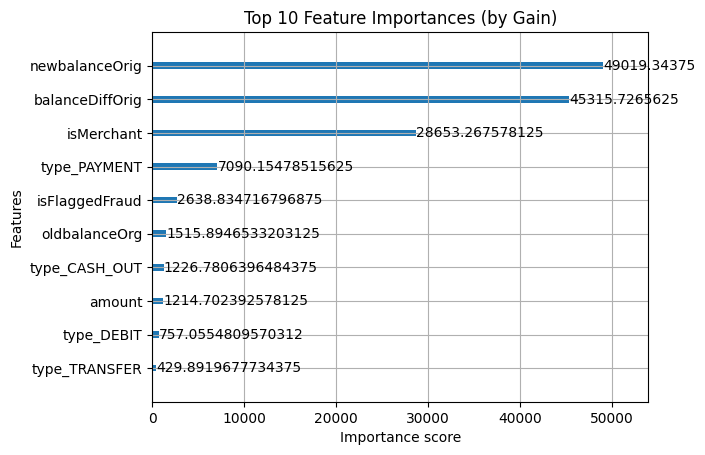

In [29]:
# Plot built-in importance
xgb.plot_importance(best_model, importance_type='gain', max_num_features=10)
plt.title('Top 10 Feature Importances (by Gain)')
plt.show()

##### Feature Importances:
- newbalanceOrig (highest importance) - Directly tells how much money is left after a transaction. Fraudulent transactions often drain the account, balance drops sharply.
- balanceDiffOrig (difference between old and new balances) - Captures the transaction impact, big sudden jumps/drop resulting in suspicious activity.
- isMerchant - Transactions targeting merchants behave differently from person-to-person, fraud patterns might avoid or exploit merchant rules.
- isFlaggedFraud - This is a business rule flag (e.g., transfer over 200k), even if not perfect, it gives a strong prior signal to the model.
- type_PAYMENT, type_CASH_OUT, type_TRANSFER - Transaction type matters, fraudsters often favor CASH_OUT and TRANSFER to siphon funds quickly.
The model learns which types carry higher risk.
- oldbalanceOrg, amount - Raw balances and transaction amounts still hold predictive power, especially when combined with engineered differences.

##### What kind of prevention should be adopted when updating company infrastructure?
- Strengthen authentication & access: Multi-factor authentication (MFA), Role-based access control (RBAC), Regularly rotate credentials, especially for sensitive systems.
- Secure data pipelines: Encrypt transactions (at rest and in transit), Monitor data integrity across systems.
- Real-time fraud monitoring: Integrate this trained fraud detection model into live systems. Flag or block suspicious transactions before they complete.
- Resilience & fallback: Backup critical data regularly. Maintain failover systems in case of attacks or breaches.
- Continuous updating & patching: Keep all systems (software, firmware, databases) updated against known vulnerabilities.

##### How would you determine if these actions work?
- Measure with clear KPIs over time: Reduction in fraudulent transactions (detected + successful). Decrease in financial loss from fraud events. Increase in fraud detection precision (fewer false alarms). System downtime or failure incidents related to fraud attempts.
- A/B Testing or Rollouts: Deploy the updated infrastructure gradually. Compare fraud metrics between old and new setups.
- Monitor model performance: Track metrics like precision, recall, F1-score, ROC AUC on live data. Watch for concept drift (patterns of fraud changing over time).
- User & system feedback: Monitor customer complaints, false positive rates, transaction delays. Check system logs for blocked vs. successful attacks.